# Jupyter Notebook Interface of SoS

[Jupyter](http://jupyter.org/) notebook is a web application that allows you to create documents with live code and results. The underlying interpreters of the cells are called **kernel**. For example, you can use a `python` kernel to interpret python expressions, or a `ir` kernel to interpret `R` commands. You can use sos within a `python` kernel by loading the [`sos_magic` ipython extension](../tutorials/Using_SoS_with_IPython.html), or use a `sos` kernel to work in a complete SoS environment.

In addition to the ability to execute SoS workflows within Jupyter, the SoS kernel allows you to start subkernels (e.g. [`irkernel`](https://github.com/IRkernel/IRkernel) for [the R langauage](https://www.r-project.org/)) and switch between the subkernels in the same notebook. This allows for truly integrated data analysis using different langauages.

## Installing the SoS kernel

The SoS installation process will install a SoS kernel by default. To verify if you have the sos kernel installed, use command `jupyter kernelspec list` from command line (here we use the `!` magic to run commands from Jupyter notebook):

In [1]:
!jupyter kernelspec list

Available kernels:
  python3    /Users/bpeng1/bin/anaconda/lib/python3.5/site-packages/ipykernel/resources
  ir         /Users/bpeng1/Library/Jupyter/kernels/ir
  sos        /Users/bpeng1/bin/anaconda/share/jupyter/kernels/sos


and check if you have `sos` listed as one of the kernels. If not, try to re-install SoS using `pip3 install sos --upgrade` or clone SoS locally and run `python setup.py install`. If the kernel is installed, fire Jupyter using command
```
$ jupyter notebook
```
from the `New` button to the top right corner, select `SoS`, and create a SoS notebook.

You can also start a qtconsole with the SoS kernel using command
```
$ jupyter qtconsole --kernel sos
```
or even [use the SoS kernel in Spyder](../tutorials/Using_SoS_with_Spyder.html). Most of the features described in this section also applies to `qtconsole` and `spyder`.

Note that SoS uses [imagemagick](http://www.imagemagick.org/script/index.php) and python package [`wand`](http://docs.wand-py.org/en/0.4.2/) to preview output files so it is recommended that you install these packages.

## Acceptable statements

You can enter any SoS expression, statements, and workflows in a Jupyter notebook. More specifically, you can enter

* any Python expression and statements. For example, you can write pieces of SoS code and evaluate them

In [2]:
res_path = '/path/to/resource'
ref_genome = "${res_path}/hg19"

* any SoS actions in function or script format. For example, you can execute a shell script using

In [3]:
run:
    echo Reference genome is located at ${ref_genome}

Reference genome is located at /path/to/resource/hg19


* markdown cells to document your workflow. These cells are not evaluated by SoS so string interpolations are not available to these cells.

* SoS workflows with one or more steps.

In [4]:
[10]
print("I am in ${step_name}")
[20]
print("I am in ${step_name}")
[30]
print("I am in ${step_name}")

I am in default_10
I am in default_20
I am in default_30


Technically speaking, SoS prefixes input with a default header if no header is present, and execute all input as SoS workflows. The major differences between running SoS scripts in batch mode and Jupyter notebook is the scope of variables. Whereas in Jupyter notebook all scripts are executed in the same namespace (SoS dictionary) with shared variables, SoS batch mode executes each step in separate processes with their own namespaces, with additional rules such as readonly global variables.

## Use of subkernels

One of the most important features of the SoS kernel is its support for multiple Jupyter subkernel. Using a `%use kernel` magic, you can start (and/or switches to) an alternative jupyter kernel and use a completely different script in the same notebook.

A `kernel` can be any [Jupyter supported kernels](https://github.com/ipython/ipython/wiki/IPython-kernels-for-other-languages) that have been installed locally. In particular, you can use `ir` for R kernel, `python3` for python3, `iperl` for perl, `bash` for bash. Please refer to [IRKernel](https://github.com/IRkernel/IRkernel) for instructions on how to install the `ir` kernel for `R`.

For example,

In [5]:
%use R

starts and switches to a `ir` kernel so that you can enter any R commands as if you are working on a notebook with a `ir` kernel. Note that `R` stands for a SoS language extension that uses kernel `ir` and you have to use the kernel name (e.g. `iperl`) if there is no language extension for the kernel.

In [6]:
require(graphics)
pairs(mtcars, main = "mtcars data")

As you can see, a different style is used for cells executed by the `ir` kernel. After you are done with the `ir` kernel, you can switch back to the SoS kernel using magic

In [7]:
%use sos

The `%use` magic switches to a new default kernel that would be used for any new cell, but it does not change the kernel of existing cells. The `ir` kernel will still be used if you re-evaluate the above cell in `R`.

SoS will interpolate cell content before it is passed to the subkernel. For example, if you save a dataframe to a file with name in `filename`,

In [8]:
import pandas as pd
import numpy as np
data = pd.DataFrame(np.random.randn(6,4),columns=list('ABCD'))
filename = 'mydata.csv'
data.to_csv(filename, index=False)
data

A         B         C         D
0 -0.080236 -1.185806 -0.666644 -0.217088
1 -0.834922 -0.407410  0.059401  1.751014
2 -0.636459 -0.110253  0.138277  0.336033
3  0.425266  1.004583 -1.805501  0.375769
4  0.097741 -0.781354  0.036256 -1.534463
5 -0.046473 -0.466750 -0.032544  0.020554

you can pass the filename to kernel `ir` using `${filename}` as follows

In [9]:
%use R
d <- read.csv(${filename!r})
d

d <- read.csv('mydata.csv')
d
## -- End interpolated command --


A           B          C           D          
1 -0.08023604 -1.1858061 -0.66664417 -0.21708807
2 -0.83492228 -0.4074096  0.05940068  1.75101425
3 -0.63645899 -0.1102526  0.13827724  0.33603269
4  0.42526555  1.0045830 -1.80550058  0.37576934
5  0.09774097 -0.7813538  0.03625609 -1.53446308
6 -0.04647287 -0.4667498 -0.03254394  0.02055402

## Exchange of variables between subkernels

Although string interpolation allows you to **compose** scripts in other languages, it is not a particularly good way to exchange data between SoS and subkernels. Fortunately, the SoS kernel provides a mechanism to pass variables between SoS and some subkernels using SoS magics.

For example, magic `%get` can get specified SoS variables from the SoS kernel to the subkernel `ir`.

In [10]:
%get data
data

A           B          C           D          
1 -0.08023604 -1.1858061 -0.66664417 -0.21708807
2 -0.83492228 -0.4074096  0.05940068  1.75101425
3 -0.63645899 -0.1102526  0.13827724  0.33603269
4  0.42526555  1.0045830 -1.80550058  0.37576934
5  0.09774097 -0.7813538  0.03625609 -1.53446308
6 -0.04647287 -0.4667498 -0.03254394  0.02055402

SoS tries its best to find the best-matching data types between SoS and the subkernel and convert the data in the subkernel's native datatypes (e.g. Python's `DataFrame` to R's `data.frame`), so the variables you get will always be in the subkernel's native data types, not a wrapper of a foreign object (for example objects provided by `rpy2`). 

In [11]:
class(data)

[1] "tbl_df"     "tbl"        "data.frame"

Similarly, using magic `%put`, you can put a variable in the subkernel to the sos kernel.

In [12]:
data[ data < 1] = 0
data[ data > 1] = 1

In [13]:
%put data

In [14]:
%use sos
data

A    B    C    D
0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  1.0
2  0.0  0.0  0.0  0.0
3  0.0  1.0  0.0  0.0
4  0.0  0.0  0.0  0.0
5  0.0  0.0  0.0  0.0

Variables can also be transferred with options `--in` (`-i`) and `--out` (`-o`) of magics `%use` and `%with`. For example, if you would like to add `2` to all elements in `data` but not sure if `pandas` can do that, you can send the dataframe to `R`, add `2` and send it back.

In [15]:
%with R -i data -o data
data <- data + 2

In [16]:
data

A    B    C    D
0  2.0  2.0  2.0  2.0
1  2.0  2.0  2.0  3.0
2  2.0  2.0  2.0  2.0
3  2.0  3.0  2.0  2.0
4  2.0  2.0  2.0  2.0
5  2.0  2.0  2.0  2.0

## Implicit data exchange

In addition to the use of magics `%put` and `%get` and parameters `--in` and `--out` of magics `%use` and `%with` to explicitly exchange variables between SoS and subkernels, SoS automatically shares variables with names starting with `sos` among all subkernels.

For example,

In [15]:
%use R
sos_var = 100

In [16]:
%with python
sos_var += 100
print("sos_var is changed to {}".format(sos_var))

sos_var is changed to 200


In [17]:
# I am still in R
sos_var

[1] 200

In [18]:
%use sos
sos_var

200

SoS supports an increasing number of languages and provides [an interface to add support for other languages](Extending_SoS.html). If your language of choice is not yet supported, please considering adding SoS support for your favoriate kernel with a pull request.

In [19]:
# clean up
%use sos
!rm mydata.csv 

## SOS Magics

In addition to SoS statements, you can use a few SoS magics in Jupyter notebook. 

1. SoS magics have to be specified at the beginning of a cell, although they can be specified after empty lines and comments.
2. Lines ending with `"\"` will be joined so you can break long magics into multiple lines
3. Multiple magics can be used in a single cell.

SoS supports the following jupyter magics:

###  `%use` 

As shown above, the `%use kernel` magic starts or switch to a subkernel named `kernel`.The kernel will be used for the current cell and any new cell, but not for existing cells created with another kernel. The kernel can be any locally installed Jupyter kenel, or name of a **language** (e.g. `R` for kernel `ir`). A `language` is usually built upon the corresponding subkernel, with added support for data exchange between SoS and the subkernel.

`%use` magic accepts parameters `--in (-i)` and `--out (-o)`, followed by variables that will be transferred to the subkernel after starting (or switching to) the subkernel, and variables that will be transferred back to SoS before magic `%use sos`.

For example,

In [20]:
n = 5

In [21]:
%use R -i n -o ran
ran <- rnorm(n)

In [22]:
%use sos
ran

[0.89905416379405,
 1.53512630136844,
 -1.90749682292116,
 2.00747200083488,
 0.317106299067485]

Data exchange is actually performed by magics `%get` and `%put` so please refer to these magics for details.

### `%with`

  `%with kernel` also starts (or switches to) a subkernel, but kernel specified by `%with kernel` will be reset as soon as the cell is executed. This magic is therefore suitable for a quick errand to another kernel. This magic also accepts options `--in` (or `-i`) and `--out` (or `-o`), so you could use

In [23]:
%with R -i n -o ran
ran <- rnorm(n)

to get a list of normally distributed numbers using R's `rnorm` function. The current kernel is still `sos`.

In [24]:
%use

Kernel "sos" is used.


In [25]:
ran

[1.36562693992177,
 -0.337834601673364,
 -0.0749543898701478,
 -1.11142029071332,
 -2.11600522316238]

### `%preview`

The `%preview` magic preview the content of specified files or values of specified expressions **after** the execution of the current cell. For example, in a subkernel R, you can do

png("/private/var/folders/ys/gnzk0qbx5wbdgm531v82xxljv5yqy8/T/tmppz4jq8bo/a.png")
plot(seq(1,10))
dev.off()
## -- End interpolated command --


pdf 
  2

## %preview a.png

> a.png (13.5 KiB):

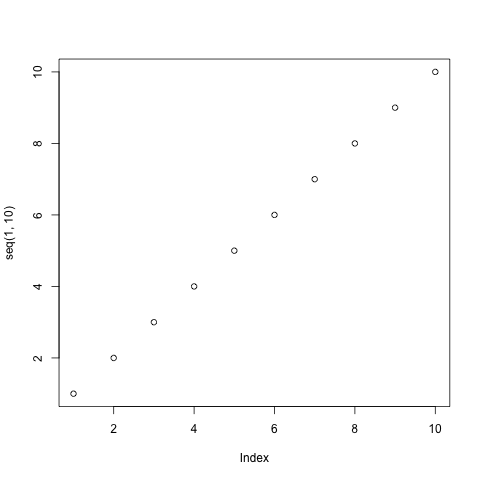

In [26]:
%sandbox
%use R
%preview a.png
png("${os.getcwd()}/a.png")
plot(seq(1,10))
dev.off()

to preview `a.png` generated by this step. Note that SoS automatically previews output files of SoS statements specified by the `output:` directive, but `output:` works only in the SoS kernel and `%preview` works for subkernel.

The `%preview` magic also accept sos variable and expressions. For example,

In [27]:
%preview data
%use sos
import pandas as pd
data = pd.DataFrame({
    'one' : pd.Series([1., 2., 3.], index=['a', 'b', 'c']),
    'two' : pd.Series([1., 2., 3., 4.], index=['a', 'b', 'c', 'd'])})

## %preview data

>>> data:

one  two
a  1.0  1.0
b  2.0  2.0
c  3.0  3.0
d  NaN  4.0

would display the content of the pandas `DataFrame`. You can specify any Python (sos) expression for this magic but, similar to command line arguments, you will need to quote the expression if it contains spaces. For example,

In [28]:
%preview data['one']

## %preview data['one']

>>> data['one']:

a    1.0
b    2.0
c    3.0
d    NaN
Name: one, dtype: float64

Magic `%preview` also accepts an option `--off`, in which case it turns off the preview of output files from the SoS workflow.

The output of the `%preview` magic would be part of the notebook. If you just want to check the value of a variable, you can inspect a variable by pressing `Shift-Tab` when you move your cursor in or after the variable. A popup window would appear with information about the variable.

Finally, if you would like to preview filename and/or variable without saving the output, you can install and use [the scratchpad Notebook Extension](https://github.com/minrk/nbextension-scratchpad). This extension allow you to open a separate panel and execute whatever statement there without affecting the current notebook.

### `%put`

Magics `%put` are used to return results from subkernel to SoS kernel when the current kernel is a subkernel started by magic `%use`. Only the `ir` and `python` kernels are supported now. Whereas there is virtually no limit on exchangeable datatypes between `SoS` and `python` kernels, there are no perfect map between Python (SoS) and `R` datatypes so SoS tries to find the best match between data types. More specifically,

  
  | R  |  length (n) |   Python |
  | --- | --- |---|
  | `NULL` | |    `None` |
  | `logical` |  `1` |  `oolean` |
  | `integer` |  `1` |  `integer` |
  | `numeric` |  `1` |  `double` |
  | `character` |  `1` |  `string` |
  | `logical` |  `n > 1` |  `list` |
  | `integer` |  `n > 1` |  `list` |
  | `numeric` |  `n > 1` |  `list` |
  | `character` |  `n > 1` |  `list` |
  | `list` without names |  `n > 0` | `list` |
  | `list` with names |  `n > 0` |  `dict` |
  | `matrix` |  `n > 0` |  `numpy.array` |
  | `data.frame` |  `n > 0` |  `DataFrame` |

For example

In [29]:
%use R
a = c(1)
b = c(1, 2, 3)
c = list(1, 2, 3)
d = list(1, 2, "3")
e = matrix(c(1,2,3,4), ncol=2)

In [30]:
%put a b c d e
%preview a b c d e

## %preview a b c d e

>>> a:

1

>>> b:

[1, 2, 3]

>>> c:

[1, 2, 3]

>>> d:

[1, 2, '3']

>>> e:

array([[ 1.,  3.],
       [ 2.,  4.]])

As you can see, although `a` is technically an array with length 1 in `R`, it is convertered to an integer in SoS. Variables `b` and `c` are converted to the same type (`list`) although they are of different types in `R`. Variable `e` are converted from `R` matrix to `numpy` array. 

Sometimes a valid variale name in a subkernel is not a valid name in SoS/Python. SoS would automatically convert such names with a warning message. For example,

In [31]:
.a.b = 5

In [32]:
%put .a.b
%preview _a_b

Variable .a.b is put to SoS as _a_b

## %preview _a_b

>>> _a_b:

5

### `%get`

Magics `%get` retrieve variables from the SoS to the current subkernel started by magic `%use`. Only the `ir` and `python` kernels are currently supported. SoS tries to use the best matching data type for the conversion. More specifically,

  
  | Python  |  condition |   R |
  | --- | --- |---|
  | `None` | |    `NULL` |
  | `boolean` |   | `logical` |
  | `integer` |  |  `integer` |
  | `float` |  |  `numeric` |
  | `str` |  | `character` |
  | Sequence (`list`, `tuple`, ...) |  homogenous type |  `c()` |
  | Sequence (`list`, `tuple`, ...) |  multiple types |  `list` |
  | `set` |  |  `list` |
  | `dict` |  |  `list` with names |
  | `numpy.ndarray` |  | `c()` array |
  | `numpy.matrix` |  | `matrix` |
  | `pandas.DataFrame` |  |  R `data.frame` |

  Python objects in other datatypes are transferred as string `"Unsupported datatype"`.

For example,

In [33]:
%use sos
a = [1, 2, 3]
b = [1, 2, "3"]
c = True

In [34]:
%use R
%get a b c
a

[1] 1 2 3

In [35]:
b

[[1]]
[1] 1

[[2]]
[1] 2

[[3]]
[1] "3"

In [36]:
c

[1] TRUE

The `%preview` magic cannot be used to preview variables in the subkernel so we have to list them one by one. As you can see, a Python list can be converted to `R` array or list depending on its content. 

Similar to the `%put` magic, SoS automatically translate variables with invalid Python names. For example

In [37]:
%use sos
_var = 'Hi, Bob'

In [38]:
%use R
%get _var
.var

Variable _var is passed from SoS to kernel R as .var

[1] "Hi, Bob"

In [39]:
%use sos

### `%paste`

This magic pastes content of clipboard to the cell and execute the cell. It is similar but sometimes more convenient than pasting the content using system shortcuts such as `Cmd-V` (mac). The additional options allow you to execute the pasted workflow with these options (see magic `%run` for details).

### `%run`

The `%sos` magic allows you to specify SoS options such as `-v` (verbosity), `-j` (max number of jobs), and workflow options as defined by `parameter:` keyword. A complete list of arguments can be shown using the `-h` option.

In [40]:
%use sos
%run -h

usage: run [-h] [-c CONFIG_FILE] [-t FILE [FILE ...]]
           [-b [BIN_DIR [BIN_DIR ...]]] [-r [REPORT_FILE]] [-n] [-s SIGMODE]
           [-d [DAG]] [-v {0,1,2,3,4}]
           [WORKFLOW]

Execute default or specified workflow defined in script

positional arguments:
  WORKFLOW              Name of the workflow to execute. This option can be
                        ignored if the script defines a default workflow (with
                        no name or with name `default`) or defines only a
                        single workflow. A subworkflow or a combined workflow
                        can also be specified, where a subworkflow executes a
                        subset of workflow (`name_steps` where `steps` can be
                        `n` (a step `n`), `:n` (up to step `n`), `n:m` (from
                        step `n` to `m`), and `n:` (from step `n`)), and a
                        combined workflow executes to multiple (sub)workflows
                        combined by

### `%rerun`

The `%rerun` magic re-executed the last script, which is basically content of the last cell without the magics. This allows you to re-run the last cell with or without a new set of parameters. Note that cells without a script (e.g. a cell with only magics) does not change the last executed script.

In [41]:
parameter: a = 10
[10]
print("a is set to ${a}")

a is set to 10


In [42]:
%rerun --a 20

a is set to 20


### `%set`

The `%set` magic sets a persistent sos options so you do not have to enter them each time after `%run` or `%paste`. For example, if you set `%set -v3`, you can execute all cells in the notebook at verbosity level 3 (`DEBUG`).

Note that this magic only accepts keyword arguments (with leading `-` or `--`) so you cannot use it to specify a default workflow to execute.

In [43]:
%set -v2
[10]
[20]

sos options is set to "-v2"


INFO: Running default_10: 
INFO: Running default_20: 


In [44]:
%set -v1
[10]
[20]

sos options is set to "-v1"


### `%matplotlib`

Similar to ipython's `matplotlib` magic, the `%matplotlib inline` magic allows the display of matplotlib figures inline in Jupyter notebook or qtconsole.

In [45]:
%matplotlib inline

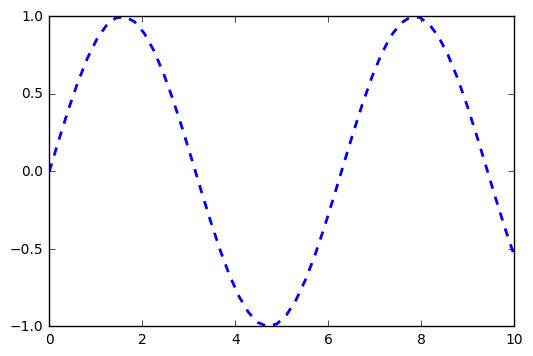

In [46]:
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(0, 10)
plt.plot(x, np.sin(x), '--', linewidth=2)
plt.show()

### `%restart`

`%restart` specified kernel without affecting the current working kernel. 

### `%dict` 

The `%dict` magic lists or rests the content of SoS dict, using syntax

```
%dict [-a|-all] [-k|--keys] [-r|--reset] [var1] [var2] ...
```

where

* `var1`, `var2` etc are name of variables. All variables will be displayed if no variable is specified.
* `-a|-all`: list all dictionary keys, including SoS functions and variables.
* `-k|--keys`: list only keys, not their values
* `-r|--reset`: reset the dictionary to its original content (with only SoS internal values)

For example, you can see all keys in the SoS dictionary using

In [47]:
%dict --keys

{'_a_b',
 '_depends',
 '_index',
 '_input',
 '_local_input_0',
 '_local_output_0',
 '_output',
 '_var',
 'a',
 'b',
 'c',
 'd',
 'data',
 'e',
 'filename',
 'local_input',
 'local_output',
 'n',
 'np',
 'pd',
 'plt',
 'ran',
 'ref_genome',
 'res_path',
 'sos_var',
 'x'}

and reset the dictionary with the `--reset` option

In [48]:
%dict --reset
%dict --keys

set()

### `%sandbox`

The `%sandbox` magic executes the current cell in the temporary directory with a separate dictionary so that it would change SoS dictionary and files in the current directory. 

This magic accepts three parameters:

1. If `-d` or `--dir` is specified, sandbox will use the specified directory. It will create the directory if it is does not exist, and will not clean or remove the directory after the completion of execution.
2. If `-k` or `--keep-dict` is specified, the cell would use the existing SoS dictionary instead of creating a new one.
3. If `-e` or `--expect-error` is specified, the cell expects an error and would return `ok` only if an `error` occurs. In practice, this option would prevent Jupyter from stopping at a cell that expects an error when you execute the whole notebook with "execute all".

For example, this `ls` commands happens at the current directory

In [49]:
!ls Auxil*

Auxiliary_Steps.ipynb


but the notebook is not available in the sandbox

In [50]:
%sandbox
!ls Auxil*

ls: Auxil*: No such file or directory


and the sandbox dictionary is empty

In [51]:
%sandbox
%dict --keys

set()

Note that the working directory of subkernels is not affected by the `%sandbox` magic.

### `%cd`

Change the current working directory of the SoS kernel to `dir`. The working directory of started subkernels is not affected.

### `!shell-command`

If any other command is entered after `!`, sos will treat the rest of the line as a shell command and execute it. Only single-line commands are supported. String interpolation is supported. Note that `!cd` does not change the current working directory because the command is executed in a separate process. Use magic `%cd` for that purpose.

The command line would accept string interpolation so you can for example do

In [52]:
import tempfile
filename = tempfile.mkstemp()[1]
with open(filename, 'w') as out:
  out.write('something\n')    

In [53]:
!cat ${filename}

cat /var/folders/ys/gnzk0qbx5wbdgm531v82xxljv5yqy8/T/tmpamqtauro
## -- End interpolated command --
something


In [54]:
# clean up
!rm ${filename}

rm /var/folders/ys/gnzk0qbx5wbdgm531v82xxljv5yqy8/T/tmpamqtauro
## -- End interpolated command --


## Code completion and variable inspection

Code completion are very useful for you to work with a SoS environment. For example, you can enter `<tab>` in
```
%<tab>
```
to get a list of available magics, in
```
%get <tab>
```
to get a list of available variables, in
```
%get dat<tab>
```
to get a list of all variables starting with name `dat`, in
```
%cd ~/<tab>
```
to get a list of all files under the home directory, and in
```
prin<tab>
```
to complete the function call to `print` if `prin` matches only `print` in the SoS namespace.

Variable inspection is an often-forgotten feature that can be really useful when you work with the SoS kernel. Basically, if you land your cursor on any sos variable or keyword, enter `<Shift-Tab>` to get some information about the variable or keyword. It is often more convenient to use than the `%preview` magic especially if you do not want to keep the output in the notebook. 

## Conversion between `.ipynb` and `.sos` files

You can save a Jupyter notebook with SoS kernel to a SoS script using `File -> Download As -> SoS` from the browser, or using command

```
$ sos convert myscript.ipynb myscript.sos
```

You can also convert an `.sos` script to `.ipynb` format using command

```
$ sos convert myscript.sos myscript.ipynb
```

or even to an executed notebook with option `--execute`

```
$ sos convert myscript.sos myscript.ipynb --execute
```

Please refer to the tutorial on [File Conversion](../tutorials/File_Conversion.html) for details of these commands.